In [2]:

import sys
import numpy as np
import xarray as xr
from glob import glob
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
import gzip
import shutil
from scipy import spatial
sys.path.append('./subroutines/')
from read_routines import read_usv,get_orbital_data_amsr2

# # Define a function to read in insitu data
# - Read in the Saildrone USV file either from a local disc or using OpenDAP.
# - add room to write collocated data to in situ dataset
# input **********************************

# ## First let's figure out what orbital files actually have data in our area of interest.  To do this, use the pyresample software
#
# - read in the in situ data
# - calculate the in situ min/max dates to know what files to check
#
# Now we have our time of interest
#
# - loop through the satellite data
# - calculate the in situ min/max lat/lon on the same day to define a small box of interest
# - use pyresample to map the data onto a predefined 0.1 deg resolution spatial grid
# - subset the gridded map to the area of interest
# - see if there is any valid data in that area
# - if there is any valid data, save the filename into a list
#
#
input_iusv_start = 0 #int(input("Enter start cruise processing number 0-10: "))
input_iusv_end = 1 #int(input("Enter stop cruise processing number 0-10: "))
adir_usv = 'C:/Users/gentemann/Google Drive/private/tem_saildrone/' # str(input("Enter directory for USV data: "))
adir_l1r = 'C:/Users/gentemann/Desktop/l1r/' #str(input("Enter directory for L1R data: "))

#intialize grid
for num_usv in range(input_iusv_start,input_iusv_end):
    ds_usv, usv_name = read_usv(adir_usv,num_usv)
    filelist = adir_usv + usv_name + 'AMSR2MMDB_filesave2_testing.nc'
    print(filelist)
    fileout = adir_usv + usv_name + 'AMSR2MMDB_usv2_testing.nc'
    df = xr.open_dataset(filelist)

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


FILEIN: C:/Users/gentemann/Google Drive/private/tem_saildrone/pmel_2015_sd126-ALL-1_min-v1.nc
C:/Users/gentemann/Google Drive/private/tem_saildrone/pmel_2015_sd126AMSR2MMDB_filesave2_testing.nc


In [9]:
df.filenames[0].values


array('C:/Users/gentemann/Desktop/l1r/amsr2/l1r/v2/2015/05/12\\GW1AM2_201505121301_075D_L1SGRTBR_2220220.h5.gz',
      dtype=object)

In [10]:
xlat, xlon, sat_time, var_data = get_orbital_data_amsr2(0, 'C:/Users/gentemann/Desktop/l1r/amsr2/l1r/v2/2015/05/12\\GW1AM2_201505121301_075D_L1SGRTBR_2220220.h5.gz')

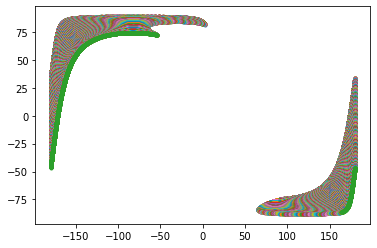

In [18]:
import matplotlib.pyplot as plt
plt.plot(xlon.data,xlat.data,'.')

In [19]:
ds_usv.lon.min().data,ds_usv.lon.max().data

(array(-175.29901), array(-163.98555))

In [34]:
cond = (xlon>=ds_usv.lon.min().data) & (xlon<=ds_usv.lon.max().data)
sub_lon = xlon.where(cond)
cond = (xlat>=ds_usv.lat.min().data) & (xlat<=ds_usv.lat.max().data)
sub_lat = xlat.where(cond)

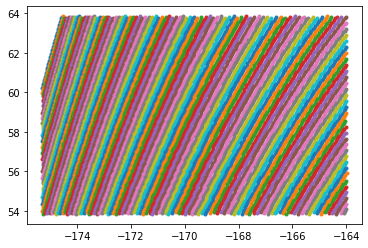

In [31]:
plt.plot(sub_lon.data,sub_lat.data,'.')

In [32]:
sub_lat

<xarray.DataArray 'Latitude of Observation Point for 89A' (phony_dim_0: 2033, phony_dim_3: 243)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: phony_dim_0, phony_dim_3
Attributes:
    SCALE FACTOR:  1.0
    UNIT:          deg

In [39]:
#drop points outside of box
usv_min_lon,usv_max_lon = ds_usv.lon.min().data-.5,ds_usv.lon.max().data+.5
usv_min_lat,usv_max_lat = ds_usv.lat.min().data-.5,ds_usv.lat.max().data+.5
cond = (xlon>=usv_min_lon) & (xlon<=usv_max_lon)
sub_lon = xlon.where(cond)
cond = (xlat>=usv_min_lat) & (xlat<=usv_max_lat)
sub_lat = xlat.where(cond)

ph0 = var_data.phony_dim_0
ph1 = var_data.phony_dim_1
tem_time = sat_time
ds = xr.Dataset({'time': (['phony_dim_0'], tem_time),
                 'tb': (['phony_dim_0', 'phony_dim_1'], var_data.data),
                 'lat': (['phony_dim_0', 'phony_dim_1'], sub_lat.data),
                 'lon': (['phony_dim_0', 'phony_dim_1'], sub_lon.data)},
                 coords={'phony_dim_0': (['phony_dim_0'], ph0),
                         'phony_dim_1': (['phony_dim_1'], ph1)})
ds2 = ds.stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
# drop nan
ds_dropa = ds2.where(np.isfinite(ds2.lon), drop=True)
ds_drop = ds_dropa.where(np.isfinite(ds_dropa.lat), drop=True)
lats = ds_drop.lat.data
lons = ds_drop.lon.data
inputdata = list(zip(lons.ravel(), lats.ravel()))
tree = spatial.KDTree(inputdata)
orbit_time = ds.time.max().data - np.timedelta64(1, 'D')
orbit_time2 = ds.time.max().data + np.timedelta64(1, 'D')
usv_subset = ds_usv.sel(time=slice(orbit_time, orbit_time2))
ilen = ds_usv.time.size
for iusv in range(ilen):
    if (ds_usv.time[iusv] < orbit_time) or (ds_usv.time[iusv] > orbit_time2):
        continue
    pts = np.array([ds_usv.lon[iusv], ds_usv.lat[iusv]])
    #        pts = np.array([ds_usv.lon[iusv]+360, ds_usv.lat[iusv]])
    tree.query(pts, k=1)
    i = tree.query(pts)[1]
    rdist = tree.query(pts)[0]
    # don't use matchups more than 25 km away
    if rdist > .25:
        continue
    # use .where to find the original indices of the matched data point
    # find by matching sss and lat, just randomly chosen variables, you could use any
    result = np.where((ds.tb == ds_drop.tb[i].data) & (ds.lat == ds_drop.lat[i].data))
    listOfCoordinates = list(zip(result[0], result[1]))
    if len(listOfCoordinates) == 0:
        continue
    ii, jj = listOfCoordinates[0][0], listOfCoordinates[0][1]
    deltaTa = ((ds_usv.time[iusv] - ds.time[ii]).data) / np.timedelta64(1, 'm')
    if np.abs(deltaTa) < np.abs(ds_usv['insitu.dtime'][iusv].data):
        ds_usv['insitu.dtime'][iusv] = deltaTa
        ds_usv.amsr2_name[iusv] = file2
        ds_usv.amsr2_dist[iusv] = rdist
        ds_usv.amsr2_scan[iusv] = ii
        ds_usv.amsr2_cell[iusv] = jj


NameError: name 'file2' is not defined

In [41]:
ii,jj


(410, 63)

In [44]:
xlat[ii,jj].data,xlon[ii,jj].data

(array(56.966248, dtype=float32), array(-170.35097, dtype=float32))